In [ ]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/petersim1/deep-image-prior
!mv deep-image-prior/* ./

In [1]:
import sys
sys.path.append("../")

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [3]:
def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.
    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        tot_loss = []
        for j in range(100):
            optimizer.zero_grad()
            loss = closure()
            tot_loss.append(loss.item())
            optimizer.step()

        print('Starting optimization with LBFGS')        
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        tot_loss = []
        for j in range(num_iter):
            optimizer.zero_grad()
            loss = closure()
            tot_loss.append(loss.item())
            optimizer.step()
    else:
        assert False

    return tot_loss

In [4]:
# deJPEG 
#fname = 'data/denoising/snail.jpg' #256x384

## denoising
#fname = 'project_extension/data/F16_GT.png' #512x512

#fname = 'project_extension/data/lena.png'

fnames = ['data/F16_GT.png',
          'data/lena.png',
          'data/peppers.png']

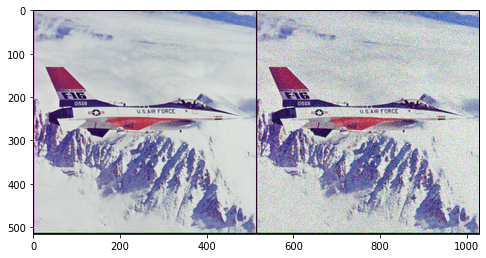

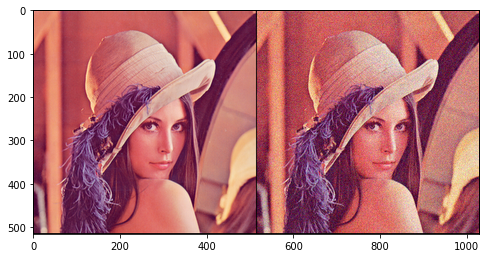

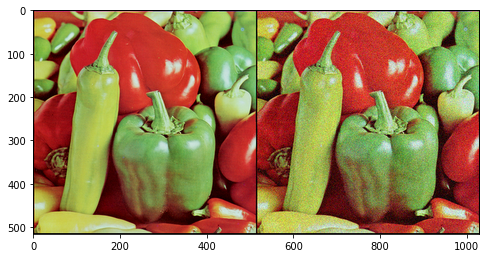

In [5]:
img_nps, img_noisy_nps = [],[]

for fname in fnames :
    if fname == 'data/denoising/snail.jpg':
        img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
        img_noisy_np = pil_to_np(img_noisy_pil)
        
        # As we don't have ground truth
        img_pil = img_noisy_pil
        img_np = img_noisy_np
        
        if PLOT:
            plot_image_grid([img_np], 4, 5);
            
    elif fname in ['data/F16_GT.png','data/peppers.png',
                  'data/lena.png','data/baboon.png']:
        # Add synthetic noise
        img_pil = crop_image(get_image(fname, imsize)[0], d=32)
        img_np = pil_to_np(img_pil)
        
        img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
        
        if PLOT:
            plot_image_grid([img_np, img_noisy_np], 4, 6);
    else:
        assert False

    img_nps.append(img_np)
    img_noisy_nps.append(img_noisy_np)

In [7]:
INPUT = 'noise' # 'meshgrid'
noise_type = 'u'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

if fnames[0] == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fnames[0] in ['data/F16_GT.png','data/peppers.png',
               'data/lena.png','data/baboon.png']:
    num_iter = 3000
    input_depth = 4
    figsize = 4 
    
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=4, 
                  skip_n33u=4, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False


net_inputs = []
for img in img_nps :
    net_input = get_noise(input_depth, INPUT, (img.shape[1], img.shape[2]),noise_type=noise_type).type(dtype).detach() #pulls from common_utils.py
    net_inputs.append(net_input)
net_inputs = torch.cat(net_inputs)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

# Convert noisy images to tensors. In minibatch format. These are "target" images.
img_noisy_torches = torch.from_numpy(np.array(img_noisy_nps)).type(dtype)


Number of params: 3435


Starting optimization with ADAM


c:\users\eelis\python37\lib\site-packages\torch\nn\functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
c:\users\eelis\python37\lib\site-packages\ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
c:\users\eelis\python37\lib\site-packages\ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
c:\users\eelis\python37\lib\site-packages\ipykernel_launcher.py:29: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_s

Iteration 00000    Loss 0.083169   PSNR_noisy: 9.841547   PSRN_gt: 10.088746 PSNR_gt_sm: 10.088746


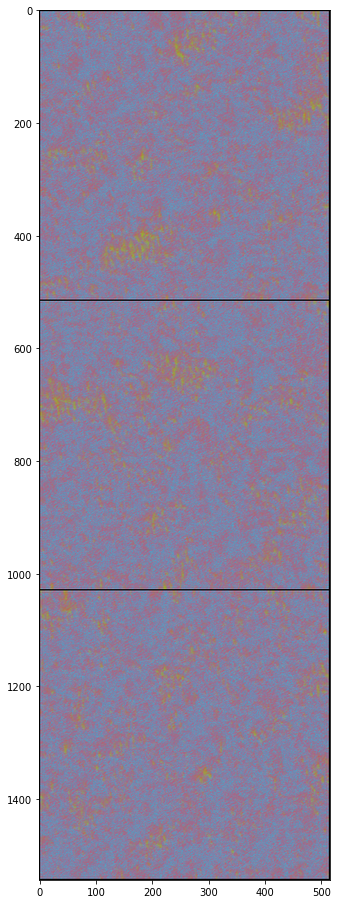

Iteration 00100    Loss 0.027999   PSNR_noisy: 7.946202   PSRN_gt: 8.082017 PSNR_gt_sm: 9.405768


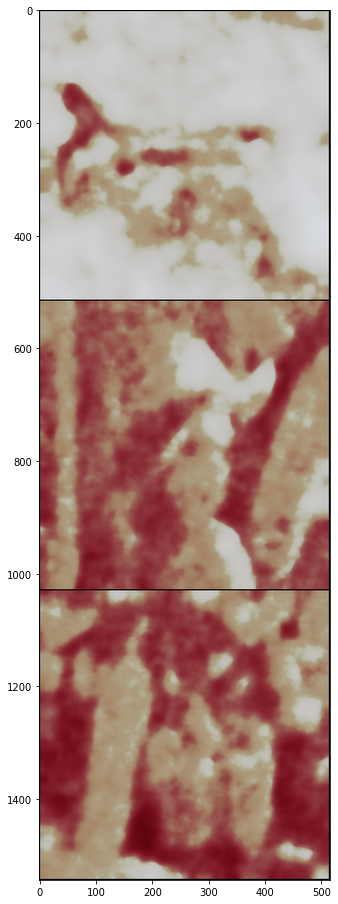

Iteration 00200    Loss 0.025766   PSNR_noisy: 7.779520   PSRN_gt: 7.909968 PSNR_gt_sm: 8.552384


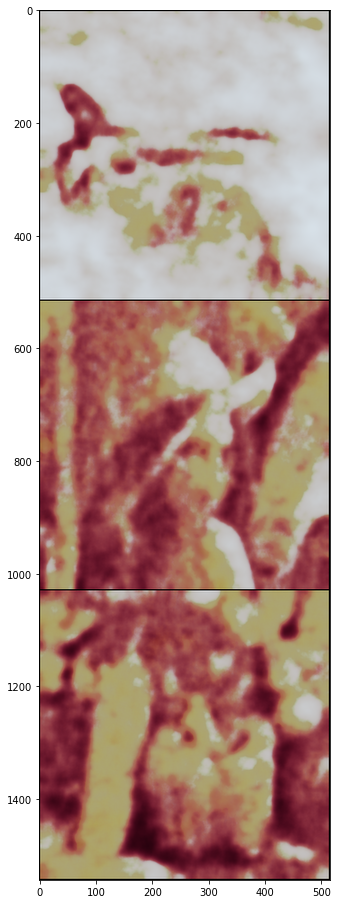

Iteration 00300    Loss 0.022557   PSNR_noisy: 7.734151   PSRN_gt: 7.864519 PSNR_gt_sm: 8.188988


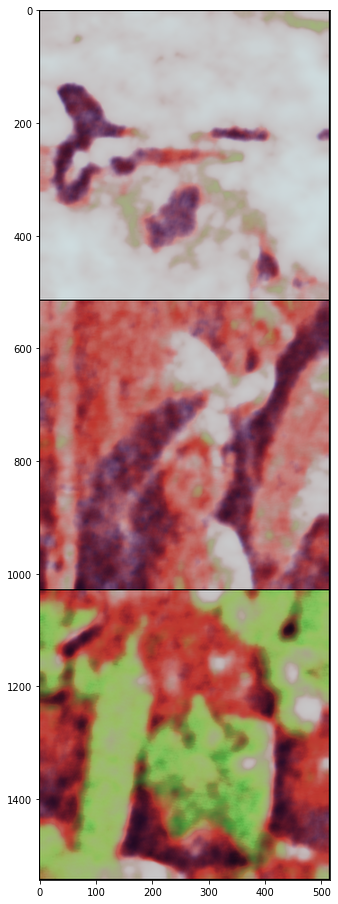

Iteration 00400    Loss 0.019936   PSNR_noisy: 7.700820   PSRN_gt: 7.828284 PSNR_gt_sm: 8.009375


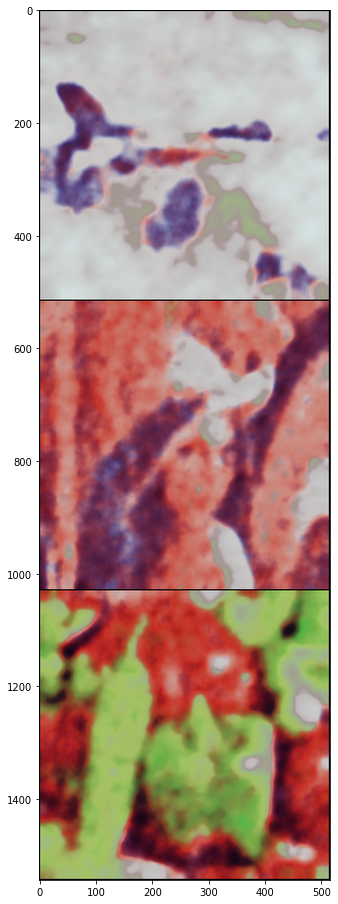

Iteration 00500    Loss 0.019421   PSNR_noisy: 7.752148   PSRN_gt: 7.881159 PSNR_gt_sm: 7.927720


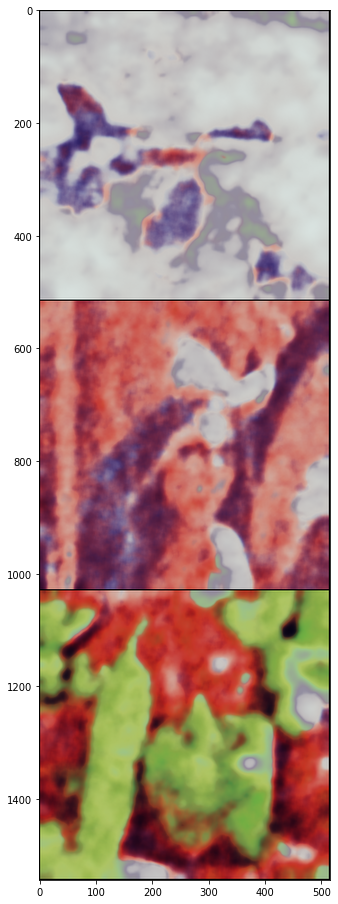

Iteration 00600    Loss 0.018750   PSNR_noisy: 7.766856   PSRN_gt: 7.897318 PSNR_gt_sm: 7.898063


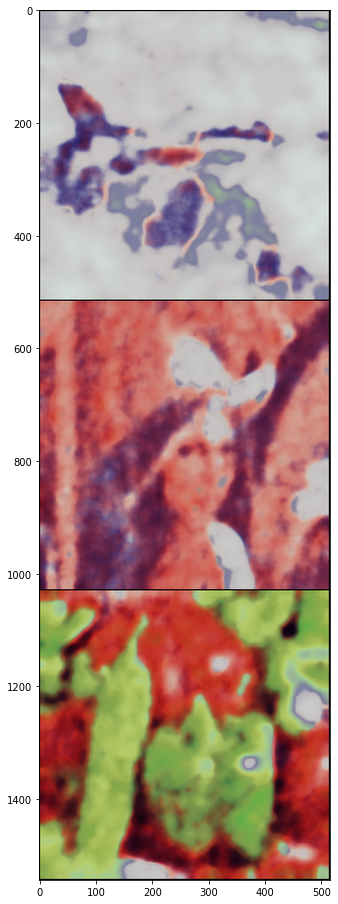

Iteration 00700    Loss 0.018961   PSNR_noisy: 7.805285   PSRN_gt: 7.937526 PSNR_gt_sm: 7.883644


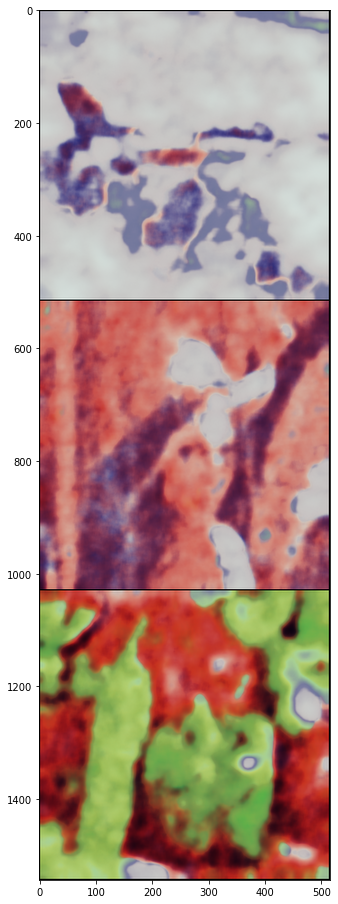

Iteration 00800    Loss 0.018240   PSNR_noisy: 7.714411   PSRN_gt: 7.842065 PSNR_gt_sm: 7.865905


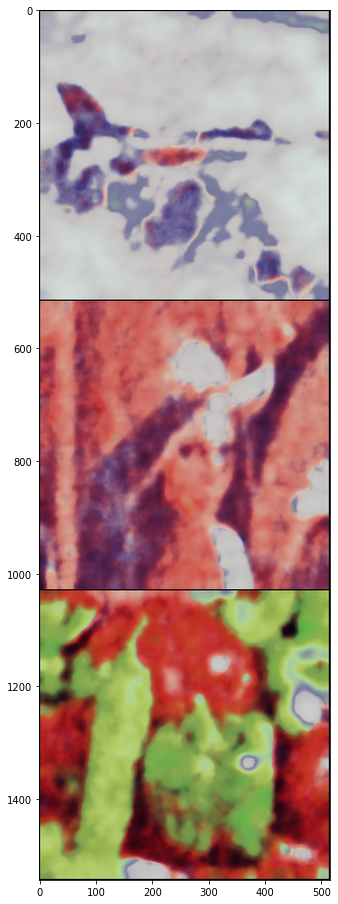

Iteration 00900    Loss 0.017795   PSNR_noisy: 7.699076   PSRN_gt: 7.827100 PSNR_gt_sm: 7.850285


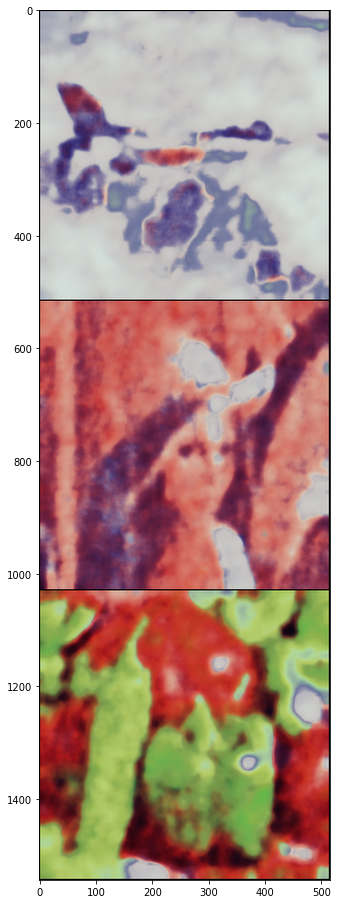

Iteration 01000    Loss 0.018094   PSNR_noisy: 7.777033   PSRN_gt: 7.908764 PSNR_gt_sm: 7.836573


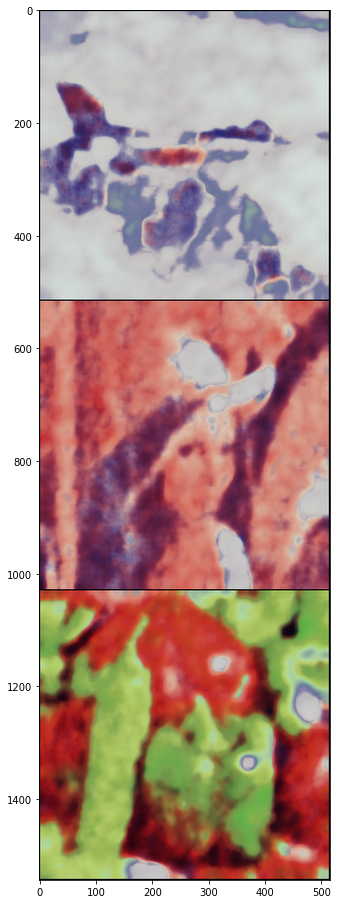

Iteration 01100    Loss 0.017515   PSNR_noisy: 7.688702   PSRN_gt: 7.815601 PSNR_gt_sm: 7.829334


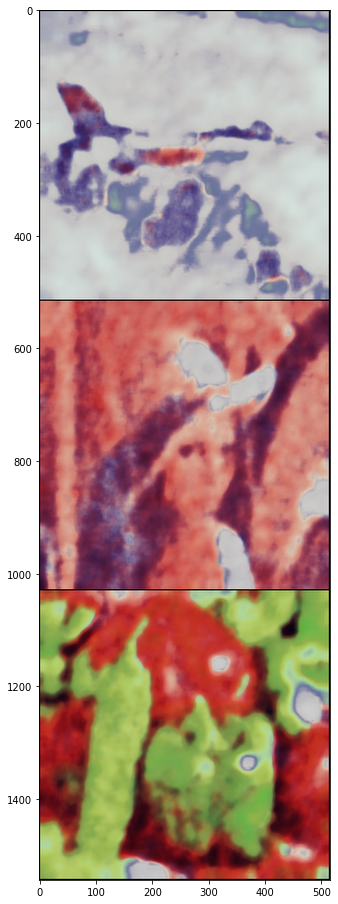

In [ ]:
net_input_saved = net_inputs.detach().clone()
noise = net_inputs.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_inputs)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torches)
    total_loss.backward()
        
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    #print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm),end='\n')
    if  PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm),end='\n')
        out_np = out.detach().cpu().numpy()
        #plot_image_grid([np.clip(out_np, 0, 1), 
        #                 np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        plot_image_grid([*np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_inputs)
losses = optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_np = net(net_inputs).detach().cpu().numpy()
#q = plot_image_grid([img_np, img_noisy_np, np.clip(out_np, 0, 1)], factor=13);
q = plot_image_grid([*out_np], factor=13);

In [ ]:
img_grid = []
for _ in range(5) :
  a = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0]),noise_type='u').type(dtype).detach()
  img_grid.append(np.clip(torch_to_np(net(a)),0,1))
q2 = plot_image_grid(img_grid, factor=13);